In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import util as utils
import os.path
from IPython.display import display
import ipywidgets as widgets


In [ ]:
precision = 0.005 # m/z precision for raw data
data_per_sec = 2 # spectrum per second
half_time_window = 30 # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 8000 #  everything under this will be annotated false

#attention 'A.clarkii T72hI1ctrl.mzML' empty

mzMl_folder =  'Y:/PLTF/FBM/MEP/jivanise/service/D2c/RESEARCH/QTOF DATA/Sara Heim_Banyuls_sur_mer_2021/Salamin-Aclarkii-B2_RP_NEG/'

raw_peak =  'Y:/PLTF/FBM/MEP/jivanise/service/D2c/RESEARCH/QTOF DATA/Sara Heim_Banyuls_sur_mer_2021/Salamin-Aclarkii-B2_RP_NEG/data_final_clarkii.csv'

pickle_path = './output/pickle_sample/'

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mzMl_folder) if isfile(join(mzMl_folder, f))]
print(onlyfiles)

In [ ]:
mz_files = [ 'A.clarkii T0I10ctrl.mzML', 'A.clarkii T0I10exp.mzML', 'A.clarkii T0I11ctrl.mzML', 'A.clarkii T0I11exp.mzML', 'A.clarkii T0I1ctrl.mzML', 'A.clarkii T0I1exp.mzML', 'A.clarkii T0I2ctrl.mzML', 'A.clarkii T0I2exp.mzML', 'A.clarkii T0I3ctrl.mzML', 'A.clarkii T0I3exp.mzML', 'A.clarkii T0I4ctrl.mzML', 'A.clarkii T0I4exp.mzML', 'A.clarkii T0I5ctrl.mzML', 'A.clarkii T0I5exp.mzML', 'A.clarkii T0I6ctrl.mzML', 'A.clarkii T0I6exp.mzML', 'A.clarkii T0I7ctrl.mzML', 'A.clarkii T0I7exp.mzML', 'A.clarkii T0I8ctrl.mzML', 'A.clarkii T0I8exp.mzML', 'A.clarkii T0I9ctrl.mzML', 'A.clarkii T0I9exp.mzML', 'A.clarkii T72hI10ctrl.mzML', 'A.clarkii T72hI10exp.mzML', 'A.clarkii T72hI11ctrl.mzML', 'A.clarkii T72hI11exp.mzML', 'A.clarkii T72hI1exp.mzML', 'A.clarkii T72hI2ctrl.mzML', 'A.clarkii T72hI2exp.mzML', 'A.clarkii T72hI3ctrl.mzML', 'A.clarkii T72hI3exp.mzML', 'A.clarkii T72hI4ctrl.mzML', 'A.clarkii T72hI5ctrl.mzML', 'A.clarkii T72hI5exp.mzML', 'A.clarkii T72hI6ctrl.mzML', 'A.clarkii T72hI6exp.mzML', 'A.clarkii T72hI7ctrl.mzML', 'A.clarkii T72hI7exp.mzML', 'A.clarkii T72hI8ctrl.mzML', 'A.clarkii T72hI8exp.mzML', 'A.clarkii T72hI9ctrl.mzML', 'A.clarkii T72hI9exp.mzML', 'Blank2.mzML', 'Blank4.mzML', 'Blank5.mzML', 'Blank7.mzML', 'Qcclarkii fin100%.mzML', 'Qcclarkii fin12.5%.mzML', 'Qcclarkii fin25%.mzML', 'Qcclarkii fin50%.mzML', 'Qcclarkii in100%.mzML', 'Qcclarkii in12.5%.mzML', 'Qcclarkii in25%.mzML', 'Qcclarkii in50%.mzML', 'Qcclarkii in6.25%.mzML', 'QCclarkii1.mzML', 'QCclarkii2.mzML', 'QCclarkii3.mzML']

In [115]:
class Factory:
    def __init__(self):
        self.features = {}
        self.samples = {}

    def get_feature(self):

        return [[mz, ff['rt'] * 60 ] for mz, ff in self.features.items()]

    def add_raw_peak(self, file):

        with open(file, newline='') as f:

            reader = csv.reader(f,delimiter=',')
            next(reader)

            for line in list(reader):
                self.features[float(line[2])] =  {'rt' :float(line[1]), 'manual_annotation': None, 'dl_annotation': None }

    def add_samples(self, list_file):

        cptf = 0
        for f in list_file:


            sample_id = f.replace('.mzML','')
            pick_f = pickle_path + sample_id  + '.npy'

            if not os.path.exists(pick_f):

                list_features = self.get_feature()
                datum = utils.get_data_mz_batch( mzMl_folder + f, list_features)

                X_ = datum[0]
                y_ =  datum[1]
                mz_ = datum[2]
                rt_ =  datum[3]

                with open(pick_f, 'wb') as fi:
                    np.save(fi, np.asanyarray([X_, y_, mz_, rt_], dtype=object))

            data = np.load(pick_f, allow_pickle=True)
            s = Sample(sample_id)
            s.data_ = data[0]
            s.annotation_ =  data[1]
            s.mz_ = data[2]
            s.rt_ =  data[3]

            self.samples[sample_id] = s
            print("File {} / {}".format(cptf, len(list_file)))
            cptf += 1

    def plot(self, mz):

        data_0_E = []
        data_0_C = []
        data_72_E = []
        data_72_C = []
        data_QC = []
        data_B = []

        for sample_name, sample in self.samples.items():

            idx = np.where(sample.mz_ == float(mz))[0]


            if len(idx)>0:
                if 'ctrl' in sample_name:
                    if 'T0' in sample_name:
                        data_0_C.append(sample.data_[idx[0]])
                    elif 'T72' in sample_name:
                        data_72_C.append(sample.data_[idx[0]])
                elif 'exp' in sample_name:
                    if 'T0' in sample_name:
                        data_0_E.append(sample.data_[idx[0]])
                    elif 'T72' in sample_name:
                        data_72_E.append(sample.data_[idx[0]])
                elif sample_name[0] == 'Q' and 'cond' not in sample_name:
                    data_QC.append(sample.data_[idx[0]])
                elif 'Blank' in sample_name:
                    data_B.append(sample.data_[idx[0]])


        # Initialise the subplot function using number of rows and columns
        figure, axis = plt.subplots(2, 3, figsize=(15,15))

        for fdata in data_0_C:
            axis[0, 0].plot(fdata)
        axis[0, 0].set_title("Ctrl T0" )

        for fdata in data_72_C:
            axis[1, 0].plot(fdata)
        axis[1, 0].set_title("Ctrl T72" )


        for fdata in data_0_E:
            axis[0, 1].plot(fdata)
        axis[0, 1].set_title("Exp T0" )

        for fdata in data_72_E:
            axis[1, 1].plot(fdata)
        axis[1, 1].set_title("Exp T72" )

        for qdata in data_QC:
            axis[0, 2].plot(qdata)
        axis[0, 2].set_title("QC")

        axis[0, 2].plot(data_B)
        axis[1, 2].set_title("mz:" + str(mz) + " rt:" + str(sample.rt_[idx[0]]) )


        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4,  )

        # Combine all the operations and display
        plt.show()


class Sample:
    def __init__(self, id):
        self.id = id
        self.data_ = []
        self.annotation_ = []
        self.mz_ = []
        self.rt_ = []
        self.annotation_mz = {}

In [ ]:
data = Factory()
data.add_raw_peak(raw_peak)
data.add_samples(mz_files)

In [ ]:
collector = {}

In [ ]:

def clicked(arg):
    collector[arg.mzrt[0]] = arg.mzrt[1]

for f in list(data.features.keys())[0:10]:

    rt = data.features[f]['rt']

    threshold = False
    for name,s in data.samples.items():
        idx = np.where(s.mz_ == float(f))[0]
        if max(s.data_[idx][0]) > 8000:
            threshold = True
            break

    if (rt > 0.8 and rt < 13 and threshold ):

        data.plot(f)
        layout = widgets.Layout(width='auto', height='40px') #set width and height
        button_download = widgets.Button(layout=layout, description = 'Add '+ str(f)  +' at ' + str(rt ))
        button_download.mzrt = [f, rt]
        button_download.on_click(clicked)
        display(button_download)

In [ ]:
collector

In [ ]:
reader = csv.reader(open(raw_peak),delimiter=';')
header = list(reader)[0]

reader = csv.reader(open(raw_peak),delimiter=';')
next(reader)
filtered = filter(lambda p: float(p[2]) in collector, reader)

r = list(filtered)
r.insert(0, header)

csv.writer(open(r"test.csv",'w', newline=''),delimiter=';'  ).writerows(r)

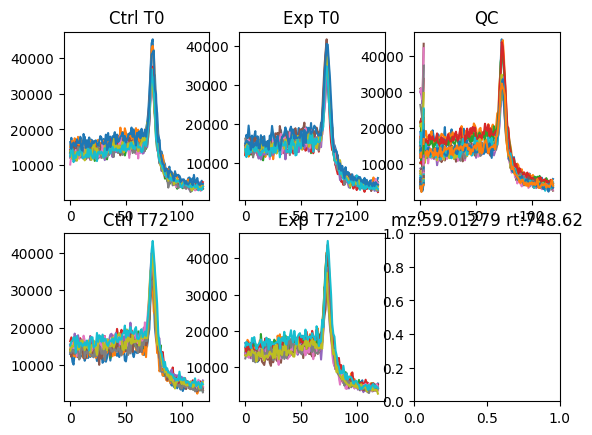

Button(description='Add 59.01279 at 12.477', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

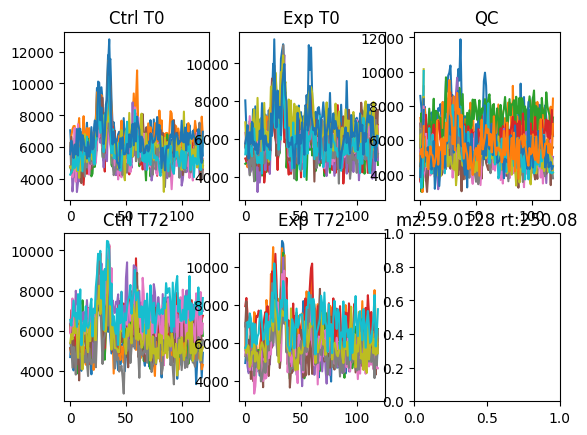

Button(description='Add 59.0128 at 4.168', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

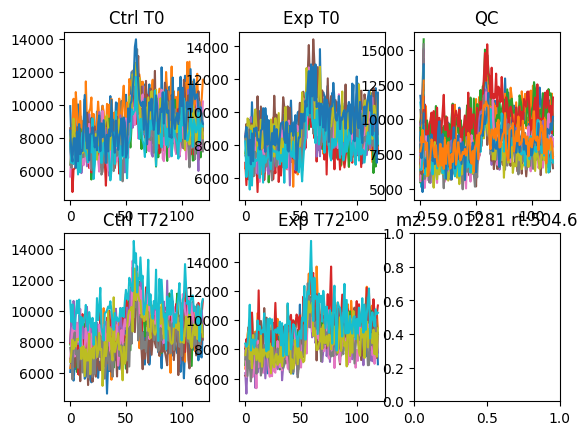

Button(description='Add 59.01281 at 8.41', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

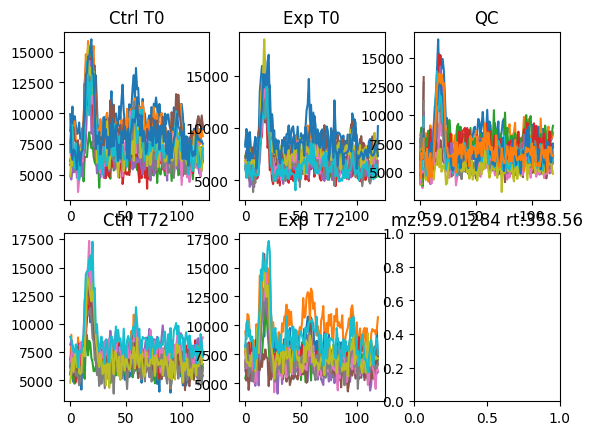

Button(description='Add 59.01284 at 5.976', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

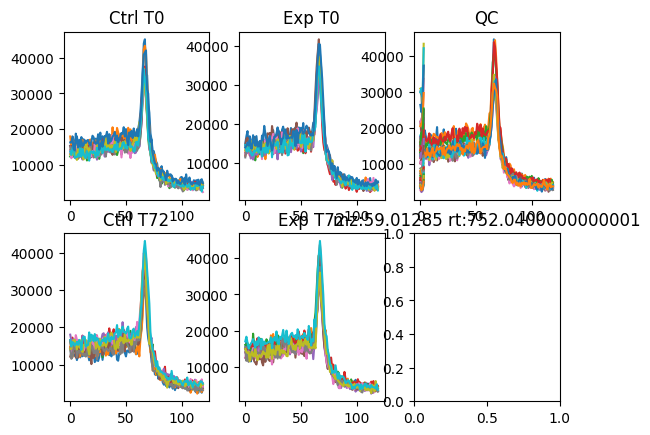

Button(description='Add 59.01285 at 12.534', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

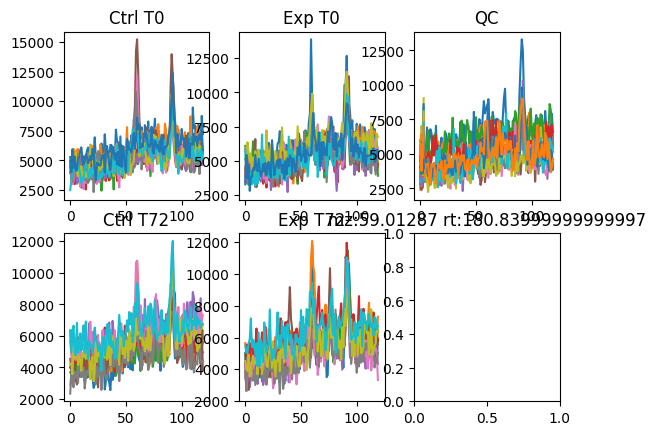

Button(description='Add 59.01287 at 3.014', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

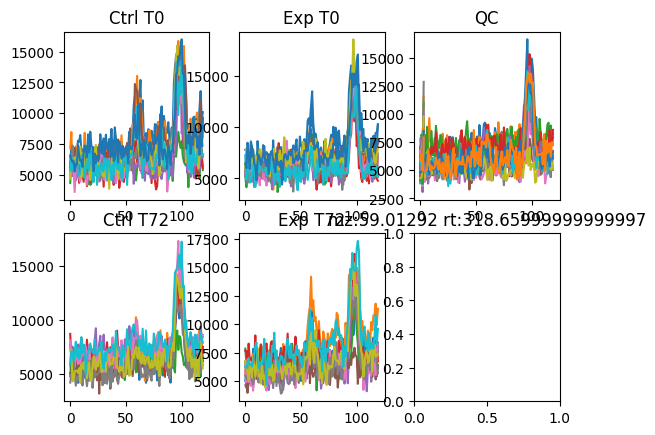

Button(description='Add 59.01292 at 5.311', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

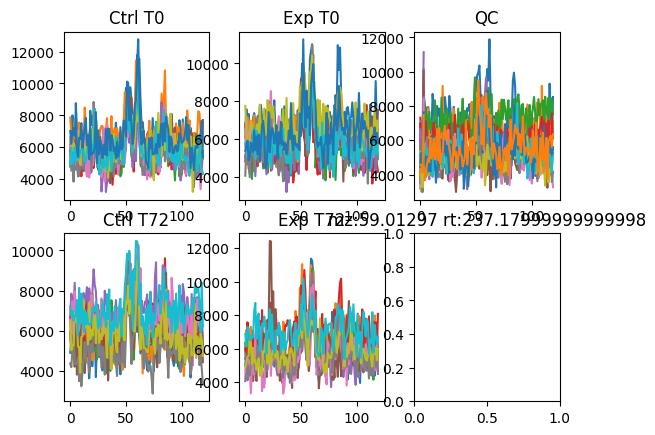

Button(description='Add 59.01297 at 3.953', layout=Layout(height='40px', width='auto'), style=ButtonStyle())

In [8]:

def clicked(arg):
    collector[arg.mzrt[0]] = arg.mzrt[1]

for f in list(data.features.keys())[0:10]:

    rt = data.features[f]['rt']

    threshold = False
    for name,s in data.samples.items():
        idx = np.where(s.mz_ == float(f))[0]
        if max(s.data_[idx][0]) > 8000:
            threshold = True
            break

    if (rt > 0.8 and rt < 13 and threshold ):

        data.plot(f)
        layout = widgets.Layout(width='auto', height='40px') #set width and height
        button_download = widgets.Button(layout=layout, description = 'Add '+ str(f)  +' at ' + str(rt ))
        button_download.mzrt = [f, rt]
        button_download.on_click(clicked)
        display(button_download)

In [11]:
collector

{59.01279: 12.477, 59.01297: 3.953, 59.01292: 5.311, 59.01287: 3.014}

In [17]:
reader = csv.reader(open(raw_peak),delimiter=';')
header = list(reader)[0]

reader = csv.reader(open(raw_peak),delimiter=';')
next(reader)
filtered = filter(lambda p: float(p[2]) in collector, reader)

r = list(filtered)
r.insert(0, header)

csv.writer(open(r"test.csv",'w', newline=''),delimiter=';'  ).writerows(r)